# About this Notebook:

Here we will be performing Data Preprocessing and Clustering.

This notebook have five parts:<br>
PART 1: Quick glance of data<br>
PART 2: Pre-clustering Processing<br>
PART 3: First-round Clustering<br>
PART 4: Second-round Clustering after applying PCA<br>
PART 5: Selected Clustering Approach

#  About the dataset:

**The columns can be further divided into the 4 feature groups (Place, Product, Promotion, People)**
1. People
1. Place
1. Product
1. Promotion

**People**

1.  Age: Customer's age (NEW)
1.  Education: Customer's education level
1.  Relationship_status: Customer's relationship status
1.  Income: Customer's yearly household income
1.  Kidhome: Number of children in customer's household
1.  Teenhome: Number of teenagers in customer's household
1.  KidTeenhome: Number of children & teenagers in customer's household (NEW)

**Product**

1.  MntWinesProducts: Amount spent on wine in last 2 years
1.  MntFruitsProducts: Amount spent on fruits in last 2 years
1.  MntMeatProducts: Amount spent on meat in last 2 years
1.  MntFishProducts: Amount spent on fish in last 2 years
1.  MntSweetProducts: Amount spent on sweets in last 2 years
1.  MntGoldProducts: Amount spent on gold in last 2 years
1.  TotalAMntspent:Total amount spend in last 2 years (NEW)

**Promotion**<br>
1.  NumDealsPurchases: Number of purchases made with a discount
1.  AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
1.  AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
1.  AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
1.  AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
1.  AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
1.  AcceptedCmpLast: 1 if customer accepted the offer in the last campaign, 0 otherwise
1.  TotalCmpAccepted: Number of offers accepted by customer (NEW)

**Place**
1.  NumWebPurchases: Number of purchases made through the company’s website
1.  NumCatalogPurchases: Number of purchases made using a catalogue
1.  NumStorePurchases: Number of purchases made directly in stores
1.  TotalNumPurchases: Total number of purchases made by a customer (NEW)
1.  NumWebVisitsMonth: Number of visits to company’s website in the last month


# Approach

||Description|
|---|---|
|Features used|Customers are clustered based on their consumer behaviour: Behaviour-related features from <code>PURHCASE</code>,<code>PLACE</code>,<code>PROMORTION</code> features|
|Data Processing|<li>Only quantitative numerical features used<li>Features scaled with <code>StandardScaler|
|Clustering algorithms|<li>KMeans<li>DBSCAN<li>Agglomerative Clustering|
|Assessing Clustering Output|<li>Silhouette score: measures how well-separated clusters are from each other (Aim: ~0.5)<li> Clusters size: Aim to have at least ~200 customers per cluster|
|Others|<li> Dimensionality reduction with Principal Component Analysis (PCA) was explored|

# Imports and Functions creation

In [1]:
import numpy as np 
import pandas as pd 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Visualisation:
import seaborn               as sns
import matplotlib.pyplot     as plt
sns.set_theme(style="whitegrid")

#model preprocessing:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Modelling
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

# Model Evaluation
from sklearn.metrics import silhouette_score


In [2]:
#Showing missing, duplicates, shape, dtypes
def df_summary(df):
    print(f"Shape(col,rows): {df.shape}")
    print(f"Number of duplicates: {df.duplicated().sum()}")
    print('---'*20)
    print(f'Number of each unqiue datatypes:\n{df.dtypes.value_counts()}')
    print('---'*20)
    print("Columns with missing values:")
    isnull_df = pd.DataFrame(df.isnull().sum()).reset_index()
    isnull_df.columns = ['col','num_nulls']
    isnull_df['perc_null'] = ((isnull_df['num_nulls'])/(len(df))).round(2)
    _df_ = isnull_df[isnull_df['num_nulls']>0]
    if _df_.empty:
        print("--No Missing Data--")
    else:
        print(_df_)

#Visualisation        
##Annotate Barchart
def annotation_fx(my_barchart):
    for each_bar in my_barchart.patches:
        plt.annotate(format(each_bar.get_height(), '.0f'),
                       (each_bar.get_x() + each_bar.get_width() / 2,
                        each_bar.get_height()), ha='center', va='center',
                       size=10, xytext=(0, 8),
                       textcoords='offset points')

In [3]:
# Data Import
cleaned_df = pd.read_csv("Data/cleaned_data.csv")
df = cleaned_df.copy()

# Part 1: Quick glance of the cleaned data

In [4]:
#quick look at the dataframe
df_summary(df)

Shape(col,rows): (2216, 27)
Number of duplicates: 185
------------------------------------------------------------
Number of each unqiue datatypes:
int64      24
object      2
float64     1
dtype: int64
------------------------------------------------------------
Columns with missing values:
--No Missing Data--


In [5]:
#quick look at the columns in the dataframe
df.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'MntWinesProducts',
       'MntFruitsProducts', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProducts', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmpLast',
       'Relationship_status', 'TotalAMntspent', 'TotalCmpAccepted',
       'TotalNumPurchases', 'Age', 'KidTeenhome'],
      dtype='object')

In [6]:
# Quick look at the only two columns that is non-numerical
df.select_dtypes(include = 'object').head()

,Education,Relationship_status
0,Graduate,Unattached
1,Graduate,Unattached
2,Graduate,Attached
3,Graduate,Attached
4,Post_grad,Attached


# Part 2: Pre-clustering Processing
**Features used for clustering**:
- We will be focusing on segmenting customers into clusters based on their <code>**CONSUMER BEHAVIOUR**</code>
- As such, we will only be using feature columns that are related their consumer behaviour only:
    - Demographic features(*e.g. Age, Income*) are excluded in forming the clusters
    
**Processing**<br>
- As Behavouriour-related features are all quantitative (numerical), we only need to scale them
- <code>[StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)</code>from sklearn is being used here

In [7]:
demograph_col = [col for col in df.columns if not any(substring in col for substring in ['Mnt', 'Cmp', 'Num'])]
behav_col = [col for col in df.columns if col not in demograph_col]

In [8]:
# Number of demographic columns
len(demograph_col)

7

In [9]:
# Number of feature columns related to consumer behaviour
len(behav_col)

20

In [10]:
# creating a sub-dataframe (sub_df) that only contain consumer behaviour information
sub_df = df.copy()
sub_df.drop(columns = demograph_col, inplace = True)

In [11]:
# As all the 20 columns are numerical, we need to scale our data before fitting into model
ss = StandardScaler()
ss_output = ss.fit_transform(sub_df)
output_col_names = list(ss.get_feature_names_out())
X = pd.DataFrame(ss_output, columns = output_col_names)

In [12]:
# Now the data is ready, and we call it our 'X'
X.head()

,MntWinesProducts,MntFruitsProducts,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProducts,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,AcceptedCmpLast,TotalAMntspent,TotalCmpAccepted,TotalNumPurchases
0,0.978226,1.549429,1.690227,2.454568,1.484827,0.850031,0.351713,1.428553,2.504712,-0.554143,0.693232,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,2.377952,1.675488,0.618045,1.310941
1,-0.872024,-0.637328,-0.717986,-0.651038,-0.633880,-0.732867,-0.168231,-1.125881,-0.571082,-1.169518,-0.131574,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.420530,-0.962358,-0.502731,-1.188023
2,0.358511,0.569159,-0.178368,1.340203,-0.146821,-0.037937,-0.688176,1.428553,-0.229327,1.291982,-0.543978,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.420530,0.280250,-0.502731,1.033278
3,-0.872024,-0.561922,-0.655551,-0.504892,-0.585174,-0.752171,-0.168231,-0.760962,-0.912837,-0.554143,0.280829,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.420530,-0.919224,-0.502731,-0.910360
4,-0.391671,0.418348,-0.218505,0.152766,-0.000703,-0.559135,1.391603,0.333796,0.112428,0.061232,-0.131574,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.420530,-0.307044,-0.502731,0.200291


# Part 3 Clustering

We will be attempting 3 sklearn clustering methods:
- [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
- [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
- [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

We will be assessing mainly the model's <code>Silhouette score</code> and the resulting cluster's size.<br>
Ideally, the resulting clusters should have:
- Silhouette score 0.5 or higher
- Clusters size minimally around 200

## 3.1 KMeans

**Inertia VS Silhuoette score**<br>
<code>Inertia</code> is a measure of how internally coherent clusters are. 
- It is calculated as the sum of squared distances of all points within a cluster to the cluster center (centroid). 
- A lower inertia score indicates that the points within a cluster are tightly packed and close to the centroid, which is desirable in clustering as it means the clusters are well separated.

<code>Silhouette score</code> measures how well-separated clusters are from each other. 
- It is calculated for each data point as the difference between the average distance to all points in the same cluster (intra-cluster distance) and the average distance to all points in the nearest neighboring cluster (inter-cluster distance), divided by the maximum of the two distances. 
- Silhouette score ranges from -1 to 1, 
- with higher values indicating better-defined clusters that are well-separated from each other.

Therefore, Inertia and Silhouette score are **complementary metrics** that can be used together to evaluate the quality of a clustering algorithm. A good clustering algorithm should have <code>low inertia</code> and <code>high Silhouette</code> score, indicating that the clusters are internally coherent and well-separated from each other.

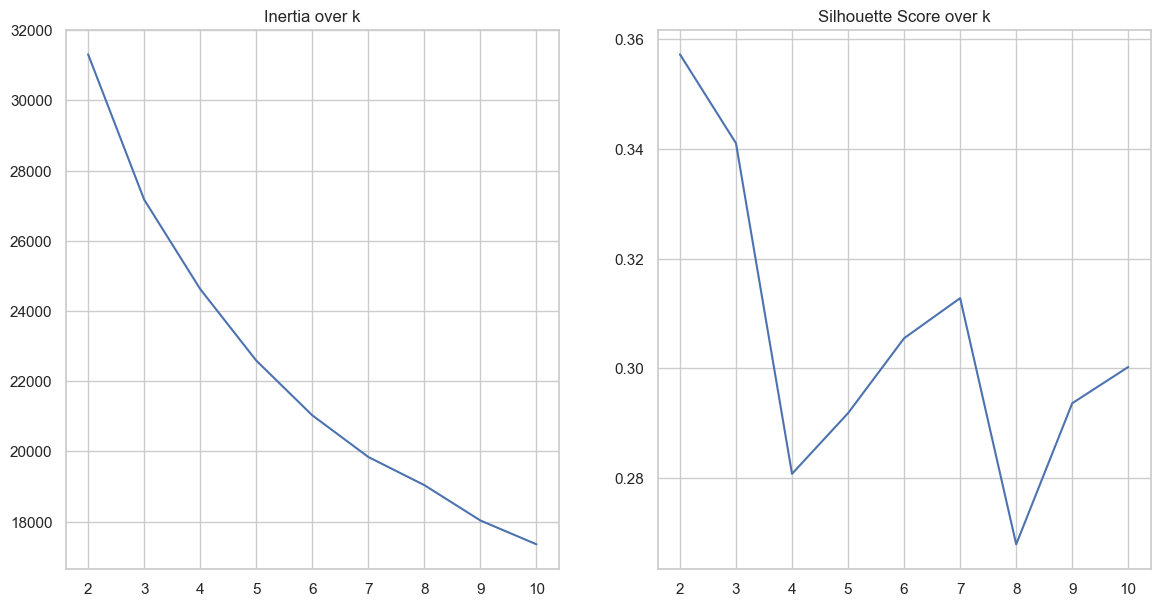

In [13]:
scores = [] 
for k in range(2, 11): # k (representing num of clusters)
    cl = KMeans(n_clusters=k)
    _ = cl.fit(X)
    inertia = cl.inertia_ # getting intertia metric scores
    sil = silhouette_score(X, cl.labels_) # getting silhouette scores
    scores.append([k, inertia, sil]) # append k (num of clusters), intertia, silhouette scores to initialized empty list
    
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']

# visualizing metrics: elbow vs silhouette
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].plot(score_df.k, score_df.inertia)
axes[0].set_title('Inertia over k')
axes[0].set_xticks(range(2, 11))

axes[1].plot(score_df.k, score_df.silhouette);
axes[1].set_title('Silhouette Score over k')
axes[1].set_xticks(range(2, 11));

In [16]:
#Looking at the Silhuoette score and the cluster size for K:
for k in [3, 6, 7]:
    cl = KMeans(n_clusters=k)
    _array = cl.fit_predict(X)
    unique_labels, counts = np.unique(_array, return_counts=True)
    counts_dict = dict(zip(unique_labels, counts))
    score = silhouette_score(X, cl.labels_).round(3)

    print (f'For {k} no. of clusters:\n  Silhuoette score: {score},\n  Cluster sizes:\n  {counts_dict}\n')

For 3 no. of clusters:
  Silhuoette score: 0.341,
  Cluster sizes:
  {0: 201, 1: 1230, 2: 785}

For 6 no. of clusters:
  Silhuoette score: 0.305,
  Cluster sizes:
  {0: 168, 1: 948, 2: 465, 3: 30, 4: 487, 5: 118}

For 7 no. of clusters:
  Silhuoette score: 0.309,
  Cluster sizes:
  {0: 122, 1: 948, 2: 433, 3: 476, 4: 118, 5: 30, 6: 89}



## 3.2 DBSCAN

Useful link explaining how to select DBSCAN parameters ([link](https://medium.com/@mohantysandip/a-step-by-step-approach-to-solve-dbscan-algorithms-by-tuning-its-hyper-parameters-93e693a91289))

In [15]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

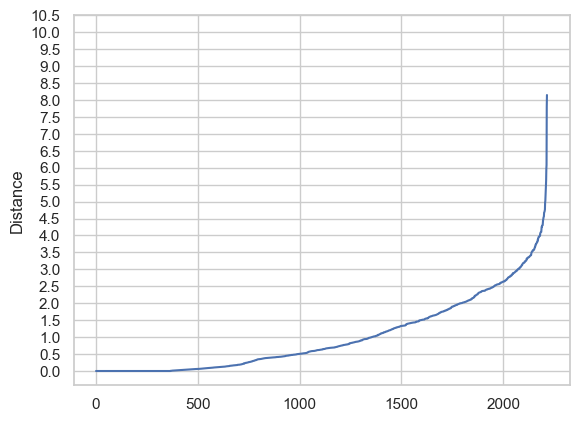

In [16]:
plt.plot(distances)
plt.yticks(np.arange(0, 11, 0.5))
plt.ylabel("Distance");

In [17]:
scores = [] 
for i in np.arange(3,4.6,0.1):
    dbscan = DBSCAN(eps=i,min_samples=5)
    _ = dbscan.fit(X)
    n_cluster = len(set(dbscan.labels_))
    sil = silhouette_score(X, dbscan.labels_)
    scores.append([i, n_cluster, sil]) 
    
score_df = pd.DataFrame(scores)
score_df.columns = ['Epsilone', 'n_cluster', 'silhouette']

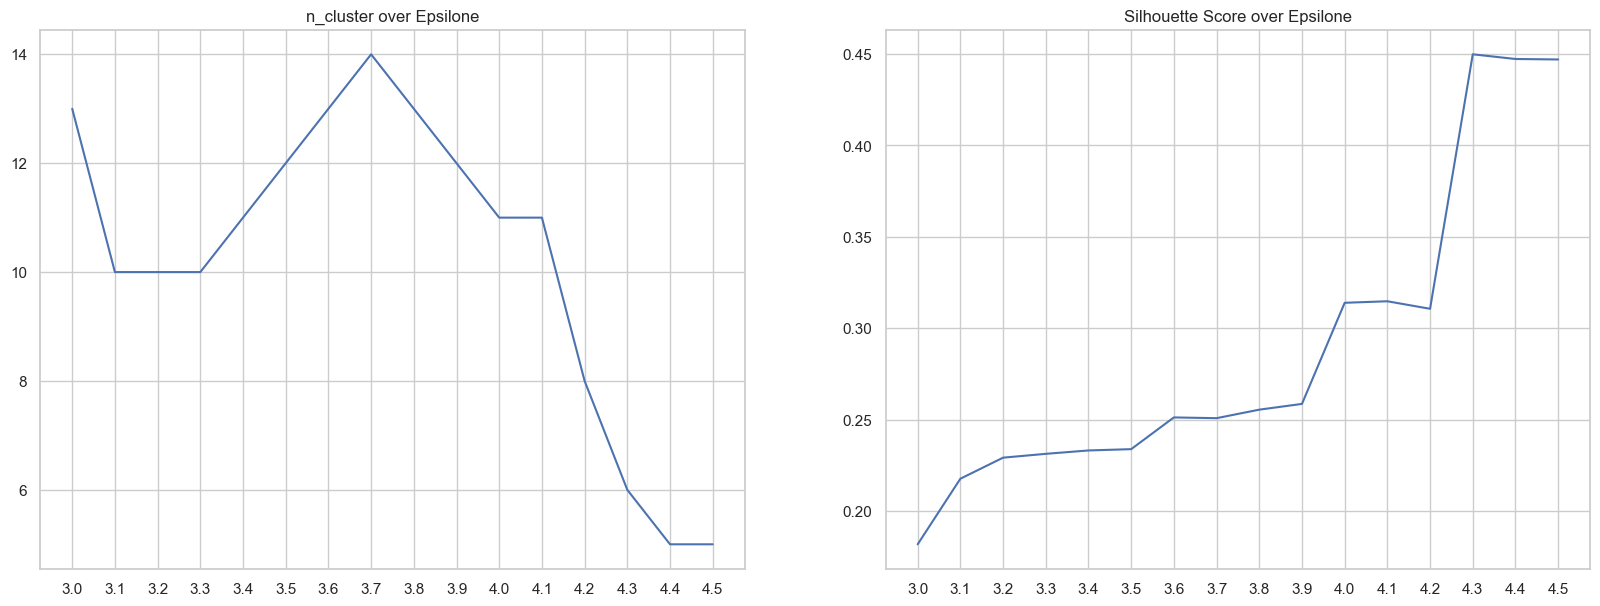

In [18]:
# visualizing metrics: elbow vs silhouette
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
axes[0].plot(score_df.Epsilone, score_df.n_cluster)
axes[0].set_title('n_cluster over Epsilone')
axes[0].set_xticks(np.arange(3, 4.6, 0.1))


axes[1].plot(score_df.Epsilone, score_df.silhouette);
axes[1].set_title('Silhouette Score over Epsilone')
axes[1].set_xticks(np.arange(3, 4.6, 0.1));



In [19]:
for eps in [4.1, 4.3, 4.4]:
    dbscan = DBSCAN(eps=eps,min_samples=5)
    _array = dbscan.fit_predict(X)
    unique_labels, counts = np.unique(_array, return_counts=True)
    counts_dict = dict(zip(unique_labels, counts))
    score = silhouette_score(X, dbscan.labels_).round(3)
  
    print (f'For epsilone:{eps},\n silhuoette score is {score},\n Value_counts:\n {counts_dict}\n')

For epsilone:4.1,
 silhuoette score is 0.315,
 Value_counts:
 {-1: 75, 0: 1954, 1: 14, 2: 58, 3: 23, 4: 51, 5: 5, 6: 6, 7: 18, 8: 6, 9: 6}

For epsilone:4.3,
 silhuoette score is 0.45,
 Value_counts:
 {-1: 61, 0: 2114, 1: 21, 2: 8, 3: 6, 4: 6}

For epsilone:4.4,
 silhuoette score is 0.447,
 Value_counts:
 {-1: 55, 0: 2141, 1: 8, 2: 6, 3: 6}



## 3.3 AgglomerativeClustering

In [20]:
scores = [] 

for i in range(3,11):
    AC = AgglomerativeClustering(n_clusters=i)
    _ = AC.fit_predict(X)

    sil = silhouette_score(X, AC.labels_)
    scores.append([i, sil]) 

score_df = pd.DataFrame(scores)
score_df.columns = ['n_cluster', 'silhouette']

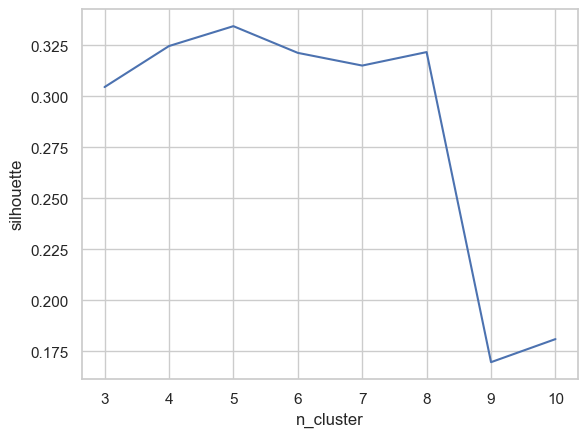

In [21]:
# visualizing 
sns.lineplot(x='n_cluster', y='silhouette', data=score_df);

In [22]:
for n in [3,6,8,10]:
    AC = AgglomerativeClustering(n_clusters=n)
    _array = AC.fit_predict(X)

    unique_labels, counts = np.unique(_array, return_counts=True)   
    counts_dict = dict(zip(unique_labels, counts))
    score = silhouette_score(X, AC.labels_).round(3)
    
  
    print (f'For n_clusters:{n},\n silhuoette score is {score},\n Value_counts:\n {counts_dict}\n')

For n_clusters:3,
 silhuoette score is 0.305,
 Value_counts:
 {0: 1265, 1: 229, 2: 722}

For n_clusters:6,
 silhuoette score is 0.321,
 Value_counts:
 {0: 326, 1: 1130, 2: 199, 3: 135, 4: 30, 5: 396}

For n_clusters:8,
 silhuoette score is 0.322,
 Value_counts:
 {0: 1130, 1: 135, 2: 396, 3: 117, 4: 30, 5: 241, 6: 85, 7: 82}

For n_clusters:10,
 silhuoette score is 0.181,
 Value_counts:
 {0: 135, 1: 117, 2: 396, 3: 82, 4: 30, 5: 241, 6: 85, 7: 484, 8: 554, 9: 92}



## Part 3 Summary
At this point:
- Silhuoette Score at best is aroud 0.3
- Customers are unevenly distributed among clusters
    - smallest cluster size can be as small as <100
    - largest cluster size can be as large as over 1900
    
**Next steps:**
- We shall explore if the clustering can be done better with the application of Principal Component Analysis (PCA)

# Part 4 Dimensionality Reduction (PCA) & Clustering

Here we re-attempt the 3 different clustering methods after selecting several features after applying PCA.

In [18]:
pca = PCA(random_state = 42)
X_pca = pca.fit_transform(X)

# Generate the cumulative explained variance.
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 20 components): {np.round(cum_var_exp[:15],3)}')

Cumulative explained variance (first 20 components): [0.378 0.506 0.592 0.657 0.699 0.738 0.773 0.806 0.837 0.865 0.893 0.917
 0.939 0.958 0.975]


In [19]:
numb_features = 4
np.round(cum_var_exp[numb_features-1],3)

0.657

In [20]:
numb_features = 6
np.round(cum_var_exp[numb_features-1],3)

0.738

In [21]:
numb_features = 8
np.round(cum_var_exp[numb_features-1],3)

0.806

## 4.1 KMeans

In [22]:
def function_km (numb_features):
    pca = PCA(n_components = numb_features, random_state = 42)
    X_pca = pca.fit_transform(X)

    scores = [] 
    for k in range(2, 21): 
        cl = KMeans(n_clusters=k) 
        _ = cl.fit(X_pca)
        inertia = cl.inertia_
        sil = silhouette_score(X_pca, cl.labels_) 
        scores.append([k, inertia, sil])

    df = pd.DataFrame(scores)
    df.columns = ['k', 'inertia', 'silhouette']
    return df, X_pca

score_4, X_pca_4 = function_km(4)
score_6, X_pca_6 = function_km(6)
score_8, X_pca_8 = function_km(8)

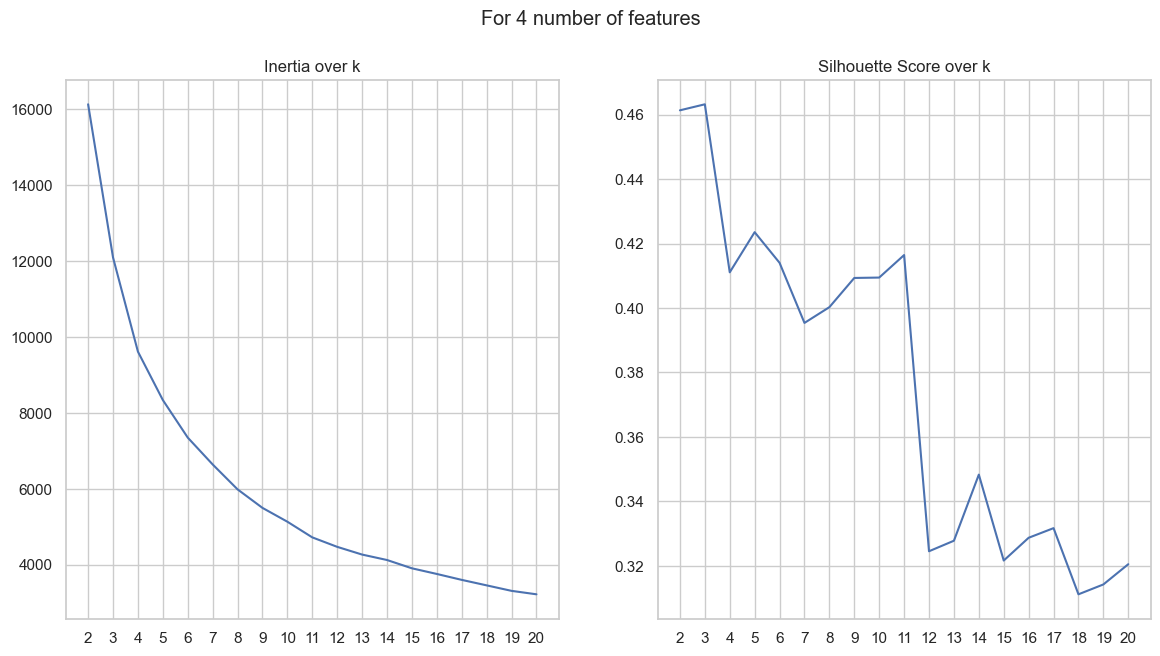

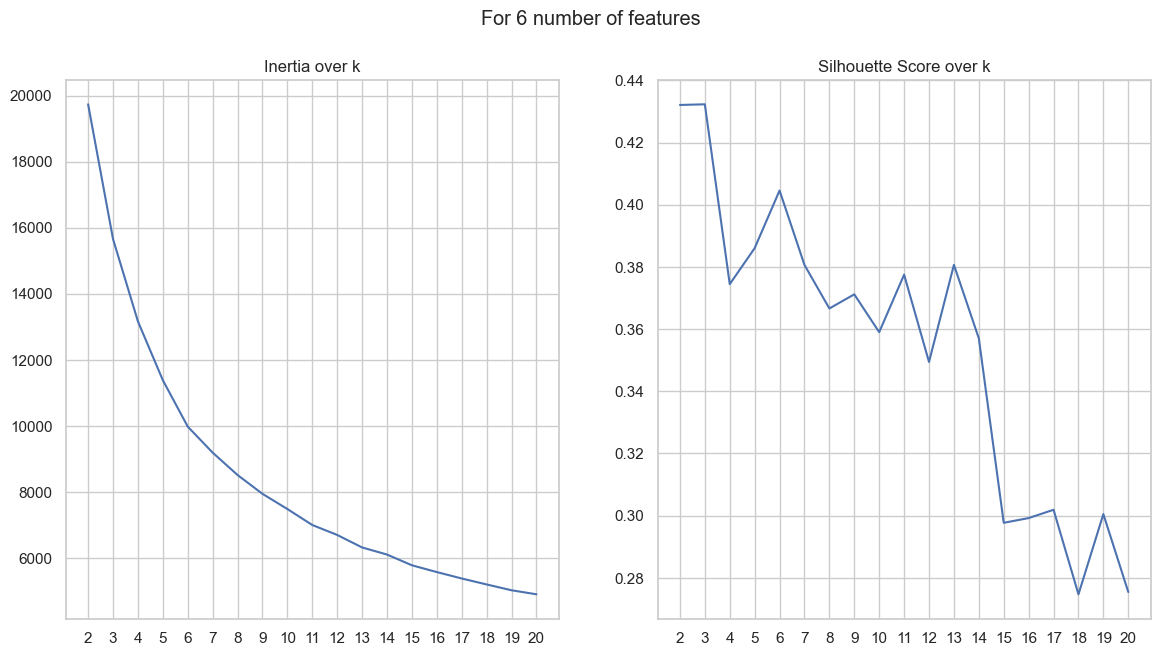

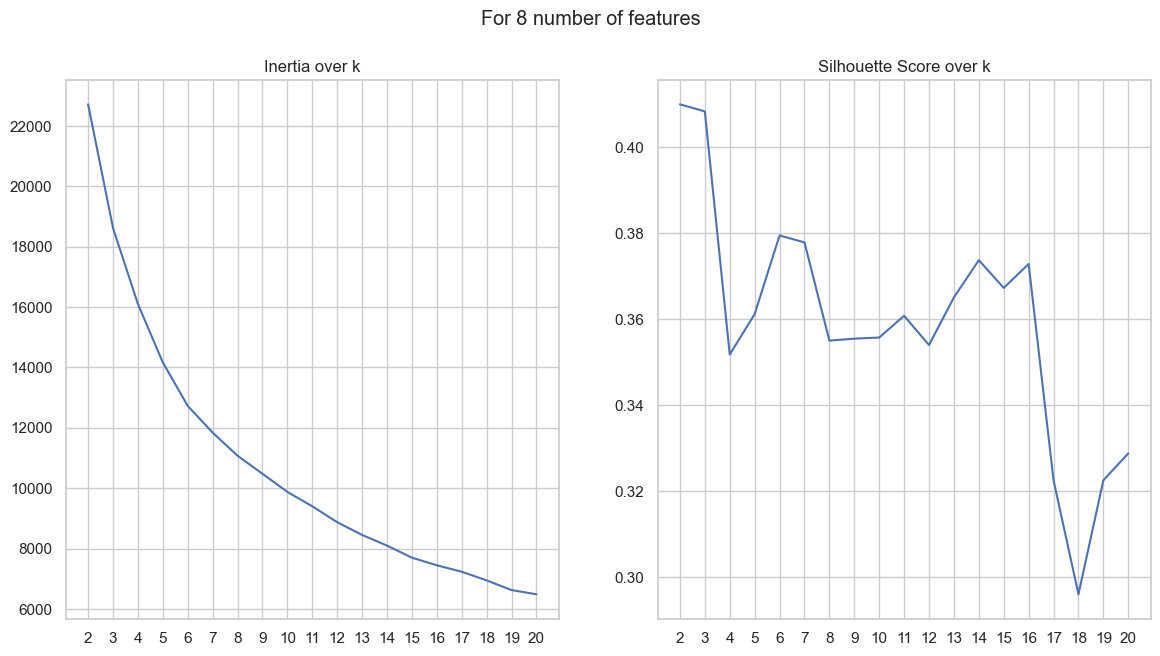

In [28]:
# visualizing metrics: elbow vs silhouette
score_ = score_4
numb_features = 4
fig, axes = plt.subplots(1, 2, figsize=(14, 7));
fig.suptitle(f'For {numb_features} number of features');
axes[0].plot(score_.k, score_.inertia);
axes[0].set_title('Inertia over k');
axes[0].set_xticks(range(2, 21));
axes[1].plot(score_.k, score_.silhouette);
axes[1].set_title('Silhouette Score over k');
axes[1].set_xticks(range(2, 21));
plt.show();

score_ = score_6
numb_features = 6
fig, axes = plt.subplots(1, 2, figsize=(14, 7));
fig.suptitle(f'For {numb_features} number of features');
axes[0].plot(score_.k, score_.inertia);
axes[0].set_title('Inertia over k');
axes[0].set_xticks(range(2, 21));
axes[1].plot(score_.k, score_.silhouette);
axes[1].set_title('Silhouette Score over k');
axes[1].set_xticks(range(2, 21));
plt.show();

score_ = score_8
numb_features = 8
fig, axes = plt.subplots(1, 2, figsize=(14, 7));
fig.suptitle(f'For {numb_features} number of features');
axes[0].plot(score_.k, score_.inertia);
axes[0].set_title('Inertia over k');
axes[0].set_xticks(range(2, 21));
axes[1].plot(score_.k, score_.silhouette);
axes[1].set_title('Silhouette Score over k');
axes[1].set_xticks(range(2, 21));
plt.show();

In [23]:
X_ls = [X_pca_4, X_pca_6, X_pca_8]
_feat = [4,6,8]
for i in range(0,3):
    numb_feature = _feat[i]
    _X = X_ls[i]
    
    print(f"\nNO. OF FEATURES: {numb_feature}\n")
    for n_cluster in [3,5,6]:
        km = KMeans(n_clusters = n_cluster) 
        _array = km.fit_predict(_X)
        unique_labels, counts = np.unique(_array, return_counts=True)
        counts_dict = dict(zip(unique_labels, counts))
        score = silhouette_score(_X, km.labels_).round(3)

        print (f'  For {n_cluster} number of clusters\n    Silhuoette Score: {score}\n    Value_counts: {counts_dict}\n')





NO. OF FEATURES: 4

  For 3 number of clusters
    Silhuoette Score: 0.463
    Value_counts: {0: 174, 1: 777, 2: 1265}

  For 5 number of clusters
    Silhuoette Score: 0.424
    Value_counts: {0: 487, 1: 913, 2: 184, 3: 157, 4: 475}

  For 6 number of clusters
    Silhuoette Score: 0.415
    Value_counts: {0: 176, 1: 882, 2: 442, 3: 452, 4: 88, 5: 176}


NO. OF FEATURES: 6

  For 3 number of clusters
    Silhuoette Score: 0.432
    Value_counts: {0: 1261, 1: 785, 2: 170}

  For 5 number of clusters
    Silhuoette Score: 0.387
    Value_counts: {0: 1021, 1: 148, 2: 513, 3: 30, 4: 504}

  For 6 number of clusters
    Silhuoette Score: 0.406
    Value_counts: {0: 495, 1: 117, 2: 953, 3: 143, 4: 30, 5: 478}


NO. OF FEATURES: 8

  For 3 number of clusters
    Silhuoette Score: 0.408
    Value_counts: {0: 1262, 1: 784, 2: 170}

  For 5 number of clusters
    Silhuoette Score: 0.361
    Value_counts: {0: 499, 1: 1030, 2: 141, 3: 516, 4: 30}

  For 6 number of clusters
    Silhuoette Score:

## 4.2 DBSCAN

In [30]:
def function_dbscan (numb_features):
    pca = PCA(n_components = numb_features, random_state = 42)
    X_pca = pca.fit_transform(X)

    neighbors = NearestNeighbors(n_neighbors=5)
    neighbors_fit = neighbors.fit(X_pca)
    distances, indices = neighbors_fit.kneighbors(X_pca)

    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    return distances, X_pca 

distances_4, X_pca_4 = function_dbscan(4)
distances_6, X_pca_6 = function_dbscan(6)
distances_8, X_pca_8 = function_dbscan(8)

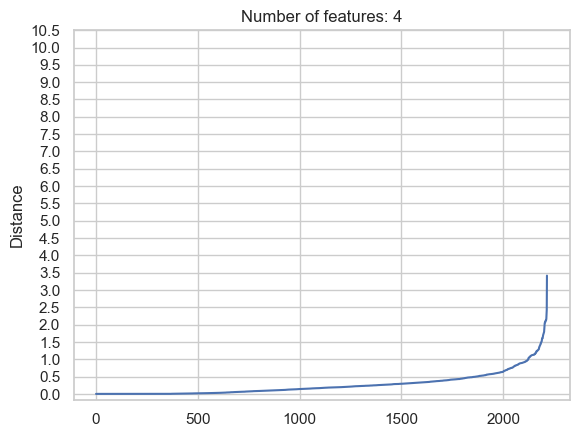

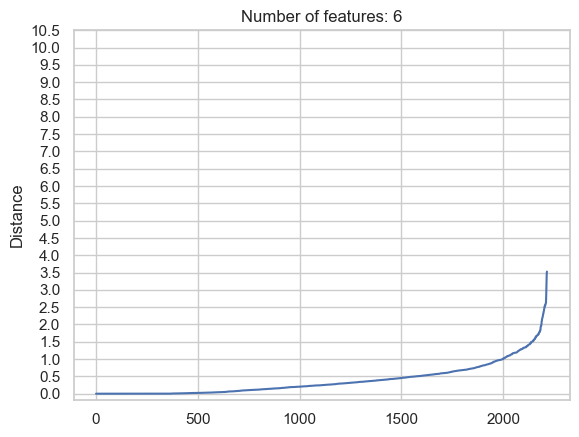

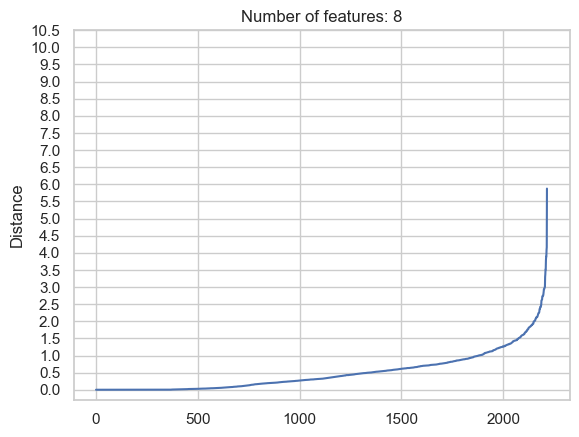

In [31]:
dist = distances_4
n_features = 4
plt.plot(dist)
plt.yticks(np.arange(0, 11, 0.5))
plt.ylabel("Distance")
plt.title(f"Number of features: {n_features}");
plt.show();

dist = distances_6
n_features = 6
plt.plot(dist)
plt.yticks(np.arange(0, 11, 0.5))
plt.ylabel("Distance")
plt.title(f"Number of features: {n_features}");
plt.show();

dist = distances_8
n_features = 8
plt.plot(dist)
plt.yticks(np.arange(0, 11, 0.5))
plt.ylabel("Distance")
plt.title(f"Number of features: {n_features}");
plt.show();

In [32]:
ep_range = np.arange(1,2.6,0.1)

def function_dbscan (X):
    scores = []
    for i in ep_range:
        dbscan = DBSCAN(eps=i)
        _ = dbscan.fit(X)
        n_cluster = len(set(dbscan.labels_))# getting intertia metric scores
        sil = silhouette_score(X, dbscan.labels_) # getting silhouette scores
        scores.append([i, n_cluster, sil]) # append k (num of clusters), intertia, silhouette scores to initialized empty list

    score_df = pd.DataFrame(scores)
    score_df.columns = ['Epsilone', 'n_cluster', 'silhouette']
    return score_df

score_4 = function_dbscan(X_pca_4)
score_6 = function_dbscan(X_pca_6)
score_8 = function_dbscan(X_pca_8)

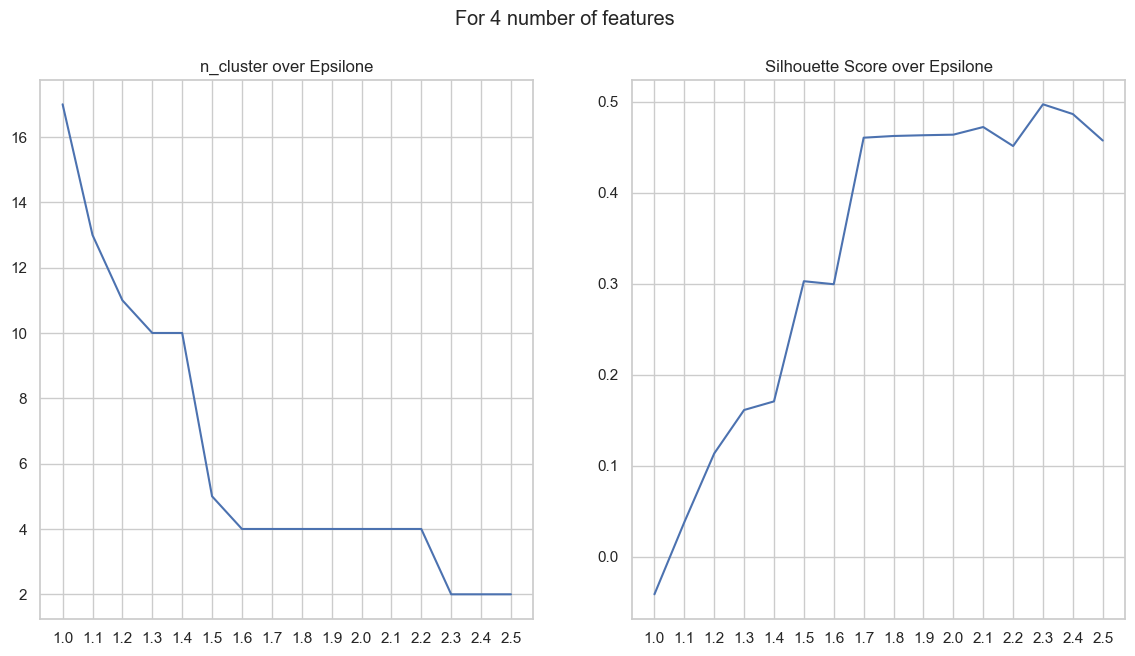

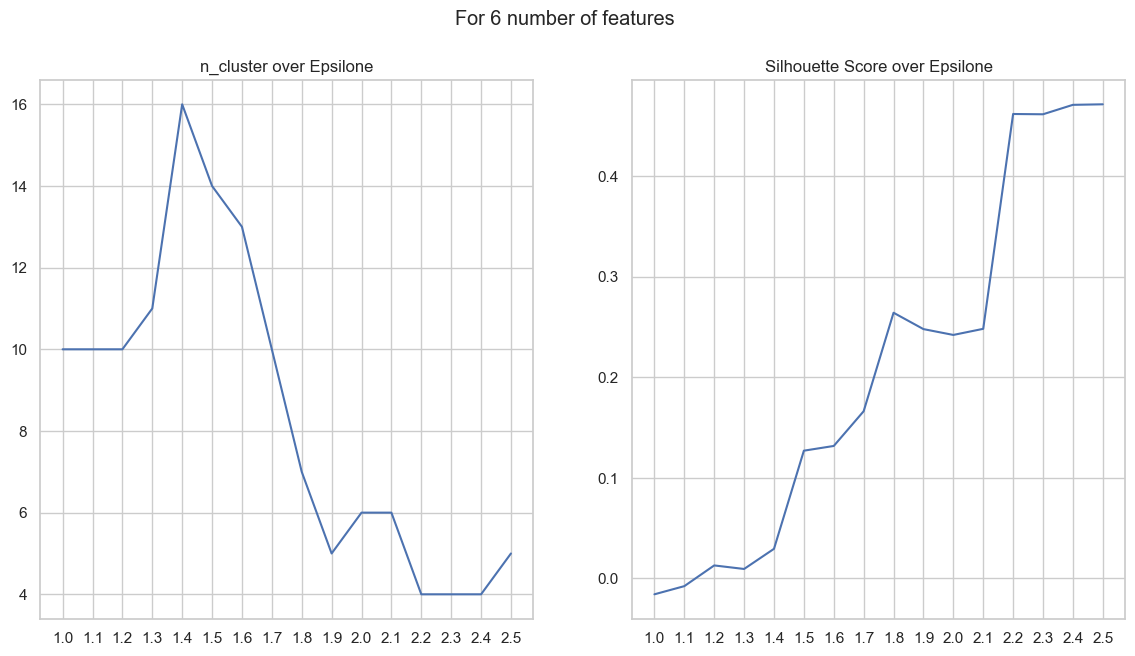

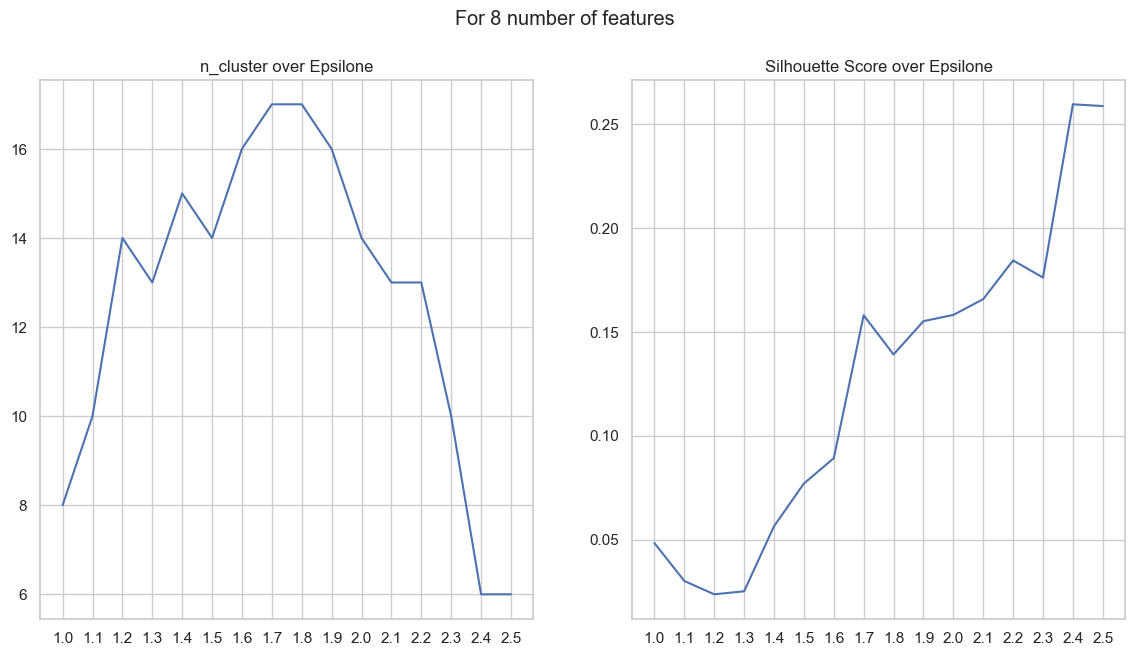

In [33]:
# visualizing 
score_df = score_4
numb_features = 4
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle(f'For {numb_features} number of features');
axes[0].plot(score_df.Epsilone, score_df.n_cluster)
axes[0].set_title('n_cluster over Epsilone')
axes[0].set_xticks(ep_range)
axes[1].plot(score_df.Epsilone, score_df.silhouette);
axes[1].set_title('Silhouette Score over Epsilone')
axes[1].set_xticks(ep_range);

score_df = score_6
numb_features = 6
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle(f'For {numb_features} number of features');
axes[0].plot(score_df.Epsilone, score_df.n_cluster)
axes[0].set_title('n_cluster over Epsilone')
axes[0].set_xticks(ep_range)
axes[1].plot(score_df.Epsilone, score_df.silhouette);
axes[1].set_title('Silhouette Score over Epsilone')
axes[1].set_xticks(ep_range);

score_df = score_8
numb_features = 8
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle(f'For {numb_features} number of features');
axes[0].plot(score_df.Epsilone, score_df.n_cluster)
axes[0].set_title('n_cluster over Epsilone')
axes[0].set_xticks(ep_range)
axes[1].plot(score_df.Epsilone, score_df.silhouette);
axes[1].set_title('Silhouette Score over Epsilone')
axes[1].set_xticks(ep_range);

In [34]:
X_ = X_pca_4
n_feature = 4
eps = 1.7
dbscan = DBSCAN(eps=eps)
_array =dbscan.fit_predict(X_)
unique_labels, counts = np.unique(_array, return_counts=True)   
counts_dict = dict(zip(unique_labels, counts))
score = silhouette_score(X_, dbscan.labels_).round(3)
print(f"DBSCAN - Number of feature: {n_feature}, epsilone: {eps}, score {score}, Value_counts: {counts_dict}")

X_ = X_pca_4
n_feature = 4
eps = 2.4
dbscan = DBSCAN(eps=eps)
_array =dbscan.fit_predict(X_)
unique_labels, counts = np.unique(_array, return_counts=True)   
counts_dict = dict(zip(unique_labels, counts))
score = silhouette_score(X_, dbscan.labels_).round(3)
print(f"DBSCAN - Number of feature: {n_feature}, epsilone: {eps}, score {score}, Value_counts: {counts_dict}")


X_ = X_pca_6
n_feature = 6
eps = 2.2
dbscan = DBSCAN(eps=eps)
_array =dbscan.fit_predict(X_)
unique_labels, counts = np.unique(_array, return_counts=True)   
counts_dict = dict(zip(unique_labels, counts))
score = silhouette_score(X_, dbscan.labels_).round(3)
print(f"DBSCAN - Number of feature: {n_feature}, epsilone: {eps}, score {score}, Value_counts: {counts_dict}")


X_ = X_pca_6
n_feature = 6
eps = 2.3
dbscan = DBSCAN(eps=eps)
_array =dbscan.fit_predict(X_)
unique_labels, counts = np.unique(_array, return_counts=True)   
counts_dict = dict(zip(unique_labels, counts))
score = silhouette_score(X_, dbscan.labels_).round(3)
print(f"DBSCAN - Number of feature: {n_feature}, epsilone: {eps}, score {score}, Value_counts: {counts_dict}")


X_ = X_pca_8
n_feature = 8
eps = 2.5
dbscan = DBSCAN(eps=eps)
_array =dbscan.fit_predict(X_)
unique_labels, counts = np.unique(_array, return_counts=True)   
counts_dict = dict(zip(unique_labels, counts))
score = silhouette_score(X_, dbscan.labels_).round(3)
print(f"DBSCAN - Number of feature: {n_feature}, epsilone: {eps}, score {score}, Value_counts: {counts_dict}")


DBSCAN - Number of feature: 4, epsilone: 1.7, score 0.46, Value_counts: {-1: 51, 0: 2155, 1: 5, 2: 5}
DBSCAN - Number of feature: 4, epsilone: 2.4, score 0.486, Value_counts: {-1: 13, 0: 2203}
DBSCAN - Number of feature: 6, epsilone: 2.2, score 0.462, Value_counts: {-1: 53, 0: 2153, 1: 5, 2: 5}
DBSCAN - Number of feature: 6, epsilone: 2.3, score 0.462, Value_counts: {-1: 50, 0: 2155, 1: 6, 2: 5}
DBSCAN - Number of feature: 8, epsilone: 2.5, score 0.259, Value_counts: {-1: 75, 0: 1999, 1: 126, 2: 5, 3: 6, 4: 5}


## 4.3 AgglomerativeClustering

In [35]:
for numb_features in [4,6,8]:
    pca = PCA(n_components = numb_features, random_state = 42)
    X_pca = pca.fit_transform(X)
    print(f"\n\n NO. OF FEATURES: {numb_features}\n")
    for n in range(4,11):
        AC = AgglomerativeClustering(n_clusters = n)
        _array = AC.fit_predict(X_pca)
        unique_labels, counts = np.unique(_array, return_counts=True)   
        counts_dict = dict(zip(unique_labels, counts))
        score = silhouette_score(X_pca, AC.labels_).round(3)

        print(f"For n_cluster: {n}, score {score} \n Value_counts: {counts_dict}")



 NO. OF FEATURES: 4

For n_cluster: 4, score 0.344 
 Value_counts: {0: 838, 1: 863, 2: 136, 3: 379}
For n_cluster: 5, score 0.305 
 Value_counts: {0: 439, 1: 863, 2: 136, 3: 379, 4: 399}
For n_cluster: 6, score 0.319 
 Value_counts: {0: 863, 1: 330, 2: 136, 3: 379, 4: 399, 5: 109}
For n_cluster: 7, score 0.352 
 Value_counts: {0: 330, 1: 399, 2: 136, 3: 379, 4: 745, 5: 109, 6: 118}
For n_cluster: 8, score 0.356 
 Value_counts: {0: 136, 1: 399, 2: 254, 3: 379, 4: 745, 5: 109, 6: 118, 7: 76}
For n_cluster: 9, score 0.356 
 Value_counts: {0: 399, 1: 379, 2: 254, 3: 66, 4: 745, 5: 109, 6: 118, 7: 76, 8: 70}
For n_cluster: 10, score 0.353 
 Value_counts: {0: 379, 1: 66, 2: 254, 3: 202, 4: 745, 5: 109, 6: 118, 7: 76, 8: 70, 9: 197}


 NO. OF FEATURES: 6

For n_cluster: 4, score 0.315 
 Value_counts: {0: 218, 1: 1021, 2: 561, 3: 416}
For n_cluster: 5, score 0.327 
 Value_counts: {0: 1021, 1: 188, 2: 561, 3: 416, 4: 30}
For n_cluster: 6, score 0.364 
 Value_counts: {0: 561, 1: 188, 2: 908, 3

## Part 4 Summary
At this point:
- Generally, the Silhuoette Score is better than in earlier attempts without applying PCA
- Observed that when Silhuoette Score gets higher, the greater the discrepancy in clusters size (e.g. cluster size can range from around 5 to 2000)
- With the aim of having a Silhuoette Score close to 0.5 while avoiding having clusters size significantly large or small, we chose KMeans Clustering with the parameters seen in the next segment.

# Part 5: Selected clustering

|**Selection**||
|---|---|
|Clustering Method|KMeans|
|Number of PCA features| 4 |
|Number of clusters| 5 |
|Cluster size| 157, 184, 479, 487, 909|
|Silhuoette score| 0.424|

In [36]:
numb_features = 4
n_cluster = 5
pca = PCA(n_components = numb_features, random_state = 42)
X_pca = pca.fit_transform(X)

km = KMeans(n_clusters = n_cluster)
_array = km.fit_predict(X_pca)
unique_labels, counts = np.unique(_array, return_counts=True)
counts_dict = dict(zip(unique_labels, counts))
score = silhouette_score(X_pca, km.labels_).round(3)

print (f"""
KMeans:
k =  {n_cluster}
Silhuoette score: {score},
Value_counts: {counts_dict}""")


KMeans:
k =  5
Silhuoette score: 0.424,
Value_counts: {0: 184, 1: 487, 2: 909, 3: 157, 4: 479}


In [37]:
df['Cluster'] = _array
df['Cluster'].value_counts()

2    909
1    487
4    479
0    184
3    157
Name: Cluster, dtype: int64

# What's Next

In the next notebook, we will profile the customers in the five clusters.

In [38]:
df.to_csv('Data/clustered_data.csv', index = False)

In [39]:
df.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'MntWinesProducts',
       'MntFruitsProducts', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProducts', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmpLast',
       'Relationship_status', 'TotalAMntspent', 'TotalCmpAccepted',
       'TotalNumPurchases', 'Age', 'KidTeenhome', 'Cluster'],
      dtype='object')